In [3]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math
print(torch.cuda.is_available())

1.24.2
2.0.0+cu117
True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_size = 9*9*8 

def create_action_dictionary():
    action_dict = {}
    index = 0
    for row in range(9):
        for col in range(9):
            for drow in range(-1, 2):
                for dcol in range(-1, 2):
                    if drow == 0 and dcol == 0:
                        continue
                    action_dict[(row, col, row+drow, col+dcol)] = index
                    index += 1
    return action_dict

action_dict = create_action_dictionary()
index_to_action = {index: action for action, index in action_dict.items()}

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_resBlocks, num_hidden, device):
        super().__init__()
        
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(11, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 9 * 9, 9 * 9 * 8)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * 9 * 9, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

value 0.12525421380996704


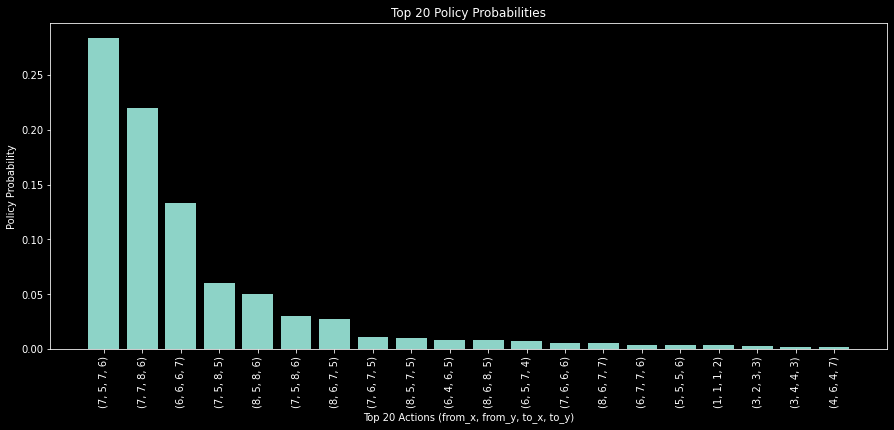

In [177]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from avalam import Board 


action_size = 9*9*8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


percepts =  [ [ 0,  0, -1, -1,  0,  0,  0,  0,  0],
              [ 0, -5, -4,  1, -5,  0,  0,  0,  0],
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
              [ 0, -1,  0,  0,  0,  0,  0,  5,  0],
              [-5,  0,  0,  0,  0, -5, -3,  0,  0],
              [ 0, -5,  0,  0,  0, -1, -2,  0,  0],
              [ 0,  0,  0,  0,  5,  0, -4,  0,  0],
              [ 0,  0,  0,  0,  0,  5,  0, -1,  0],
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0] ]
state = Board(percepts)
encoded_state = state.get_encoded_state()

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet( 9, 128, device=device)
model.load_state_dict(torch.load('model_5.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()


print("value" , value)

# Sort actions by their probabilities
sorted_actions = np.argsort(policy)[::-1]

# Select top 20 actions
top_actions = sorted_actions[:20]
top_probabilities = policy[top_actions]

# Get the action coordinates from the action indices
top_action_coordinates = [index_to_action[action_index] for action_index in top_actions]

# Create the bar plot with top 20 moves
plt.figure(figsize=(15, 6))
plt.bar(range(20), top_probabilities)
plt.xticks(range(20), top_action_coordinates, rotation=90)
plt.xlabel('Top 20 Actions (from_x, from_y, to_x, to_y)')
plt.ylabel('Policy Probability')
plt.title('Top 20 Policy Probabilities')

plt.show()

In [8]:
class MCTS() : 

    def __init__(self, model, args, device) :
        self.args = args
        self.model = model
 
        super().__init__()

    @torch.no_grad()
    def search(self, state):
        # define root 
        root = Node(self.args, state, visit_count=1)  ## board and state mean same thing 
        
        ## add noise 
        policy, _ = self.model(
                    torch.tensor(state.get_encoded_state()).unsqueeze(0).to(device)
                )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * action_size)
        
        valid_moves = np.zeros_like(policy)
        for action_index in state.get_actions_indices():
            valid_moves[action_index] = 1.0

        policy *= valid_moves 
        
        policy /= np.sum(policy)
        root.expand(policy)
        
        

        for search in range(self.args["num_searches"]):
            ## Selection 
            node = root 

            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = -node.board.get_score(), node.board.is_finished()

          
            if not is_terminal: 

                policy, value = self.model(
                    torch.tensor(node.board.get_encoded_state()).unsqueeze(0).to(device)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = np.zeros_like(policy)
                for action_index in node.board.get_actions_indices():
                    valid_moves[action_index] = 1.0

                policy *= valid_moves 
                policy /= np.sum(policy)

                value = value.item()


                ## Expansion
                node = node.expand(policy)
                
            ## Backpropagation
            node.backpropagate(value)

        ## return visit counts 
        num_actions = len(index_to_action)
        action_probs = [0] * num_actions

        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        total_visit_count = sum(action_probs)
        action_probs = [prob / total_visit_count for prob in action_probs]
        return action_probs

class Node: 
    def __init__(self, args, board, parent=None, action_taken=None ,prior=0, visit_count=0):
        self.args = args 
        self.board = board 
        self.parent = parent 
        self.action_taken = action_taken 
        self.prior = prior 

        self.children = []
        self.expandable_moves = list(board.get_actions_indices())

        self.visit_count = 0 
        self.value_sum = 0 


    def is_fully_expanded(self):
        return  len(self.children)>0 
    
    def select(self):
        best_child = None 
        best_ucb = -np.inf 

        for child in self.children : 
            ucb = self.get_ucb(child)
            if ucb > best_ucb :
                best_child = child 
                best_ucb = ucb 

        return best_child 
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):

        for action_ind, prob in enumerate(policy):
            if prob >0 : 
                ## Store position of cells and their current height that will be impacted by the move , so we can undo the move 
                store_move = []
                action = index_to_action[action_ind]
                store_move.append((action[0] , action[1] , self.board.m[action[0]][action[1]])) 
                store_move.append((action[2] , action[3] , self.board.m[action[2]][action[3]]))

                ## play move 
                self.board.play_action(action)  

                ## change perspective 
                self.board.m = -1 * np.array(self.board.m)
                child_board = self.board.clone()
                child = Node(self.args, child_board, self, action_ind, prob)
                self.children.append(child)

                ## Undo the move is restoring the cells that were changed by their old state 
                self.board.m = -1 * self.board.m
                self.board.m[store_move[0][0]][store_move[0][1]] = store_move[0][2]
                self.board.m[store_move[1][0]][store_move[1][1]] = store_move[1][2]

            
        return child

    # def simulate(self):
    #     value, is_terminal = self.board.get_score(), self.board.is_finished()
    #     value = - value 
        
    #     if is_terminal:
    #         return value
        
    #     rollout_state = self.board.clone()
    #     rollout_player = 1
    #     while True:
    #         valid_actions = list(rollout_state.get_actions())
    #         action = random.choice(valid_actions)
    #         ## play action and go to next state
    #         rollout_state.play_action(action)   
    #         value, is_terminal = rollout_state.get_score(), rollout_state.is_finished()
    #         if is_terminal:
    #             if rollout_player == -1:
    #                 value = -value 
    #             return value    
            
    #         rollout_player = - rollout_player   # change player 

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = - value 
        if self.parent is not None:
            self.parent.backpropagate(value)  



In [10]:
class AlphaZero():
    def __init__(self, model, optimizer, args):
        self.model = model 
        self.optimizer = optimizer 
        self.args = args 
        self.mcts = MCTS(model, args, device)
    
    def selfPlay(self):
        memory = []
        player = 1 
        state = Board() ## initialize game state 

        while True : 
            
            ## change perspective 
#             state.m = -1 * np.array(state.m)
            state = Board(state.m, invert = True)
            
            action_probs = self.mcts.search(state)
            
            memory.append((state.get_encoded_state(), action_probs, player))
            
            temperature_action_probs = np.array(action_probs) ** (1/self.args["temperature"])
            temperature_action_probs /= np.sum(temperature_action_probs)
            action_index = np.random.choice(action_size, p=temperature_action_probs)  ## this action is scalar 
            action = index_to_action[action_index]
            
            ## get to next state using action 
            state.play_action(action) 

            value, is_terminal = state.get_score(), state.is_finished()

            if is_terminal : 
                returnMemory = []
                for hist_neutral_state_encoded, hist_action_probs, hist_player in memory : 
                    hist_outcome = value * hist_player 
                    returnMemory.append((
                        hist_neutral_state_encoded, 
                        hist_action_probs, 
                        hist_outcome
                    ))
                return returnMemory

            player *= -1
            
            

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            optimizer.step() # change to self.optimizer
            
            

    def learn(self):
        for iteration in range(self.args["num_iterations"]):
            memory = []

            self.model.eval()
            ## machine plays with itself 
            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]):
                memory += self.selfPlay()

            ## train based on the memory collected
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
                
            iteration += self.args["start_iteration"]
            torch.save(self.model.state_dict(), f"model_{iteration}.pt" )
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")
            return memory





In [12]:
import time

model = ResNet(9, 128, device)
# model.load_state_dict(torch.load('model_2.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_2.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 6,
    'num_iterations': 1,
    'start_iteration': 3,
    'num_parallel_games': 10,
    'num_selfPlay_iterations': 10,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, args)

start_time = time.time()
memory_ = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

The code took 128.49 seconds to run.


In [13]:
time_difference/args["num_selfPlay_iterations"]

12.849417400360107

In [128]:
sample = memory
state, policy_targets, value_targets = zip(*sample)

state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            

In [129]:
for i in range(len(state)):
    print("state "+str(i)+" : score is : "+str(get_score_array(get_decoded_state(state[i])))
     + " number of moves : " + str(len(list(get_actions_indices_array(get_decoded_state(state[i]))))))

state 0 : score is : 0 number of moves : 220
state 1 : score is : 0 number of moves : 148
state 2 : score is : 1 number of moves : 170
state 3 : score is : 2 number of moves : 278
state 4 : score is : 0 number of moves : 148
state 5 : score is : -2 number of moves : 80
state 6 : score is : 0 number of moves : 220
state 7 : score is : -2 number of moves : 80
state 8 : score is : 1 number of moves : 164
state 9 : score is : -2 number of moves : 56
state 10 : score is : -2 number of moves : 20
state 11 : score is : -3 number of moves : 72
state 12 : score is : -1 number of moves : 116
state 13 : score is : -2 number of moves : 190
state 14 : score is : 1 number of moves : 244
state 15 : score is : -2 number of moves : 94
state 16 : score is : 0 number of moves : 124
state 17 : score is : -1 number of moves : 4
state 18 : score is : 2 number of moves : 138
state 19 : score is : 1 number of moves : 272
state 20 : score is : 1 number of moves : 284
state 21 : score is : 2 number of moves : 2

### Parallelization Part

In [36]:
# def get_encoded_states(states):
#     return [state.get_encoded_state() for state in states]

class InvalidAction(Exception):

    """Raised when an invalid action is played."""

    def __init__(self, action=None):
        self.action = action
        
def get_encoded_state_(state_array):
    board_size = state_array.shape[0]
    encoded_state = np.zeros((11, board_size, board_size))

    for i in range(-5, 6):
        mask = (state_array == i).astype(np.int32)
        encoded_state[i + 5] = mask

    return encoded_state.astype(np.float32)

def get_decoded_state(encoded_state):
    """
    Get the decoded state for the given encoded_state.
    
    Args:
        encoded_state (np.array): A 3D numpy array of shape (11, board_size, board_size) representing the encoded game state.
    
    Returns:
        np.array: A 2D numpy array of shape (board_size, board_size) representing the decoded game state.
    """
    board_size = encoded_state.shape[1]
    decoded_state = np.zeros((board_size, board_size), dtype=np.int32)

    for i in range(-5, 6):
        mask = encoded_state[i + 5].astype(bool)
        decoded_state[mask] = i

    return decoded_state

initial_board = [     [ 0,  0,  1, -1,  0,  0,  0,  0,  0],
                      [ 0,  1, -1,  1, -1,  0,  0,  0,  0],
                      [ 0, -1,  1, -1,  1, -1,  1,  0,  0],
                      [ 0,  1, -1,  1, -1,  1, -1,  1, -1],
                      [ 1, -1,  1, -1,  0, -1,  1, -1,  1],
                      [-1,  1, -1,  1, -1,  1, -1,  1,  0],
                      [ 0,  0,  1, -1,  1, -1,  1, -1,  0],
                      [ 0,  0,  0,  0, -1,  1, -1,  1,  0],
                      [ 0,  0,  0,  0,  0, -1,  1,  0,  0] ]
rows = 9 
columns = 9
max_height = 5 

def play_action_array(state_array, action):
    """Play an action if it is valid.

    An action is a 4-uple containing the row and column of the tower to
    move and the row and column of the tower to gobble. If the action is
    invalid, raise an InvalidAction exception. Return self.

    """
    if not is_action_valid_array(state_array,action):
        raise InvalidAction(action)
    i1, j1, i2, j2 = action
    h1 = abs(state_array[i1][j1])
    h2 = abs(state_array[i2][j2])
    if state_array[i1][j1] < 0:
        state_array[i2][j2] = -(h1 + h2)
    else:
        state_array[i2][j2] = h1 + h2
    state_array[i1][j1] = 0
    return state_array

def is_finished_array(state_array):
    """Return whether no more moves can be made (i.e., game finished)."""
    for action in get_actions_array(state_array):
        return False
    return True

def get_actions_array(state_array):
    """Yield all valid actions on this board."""
    for i, j, h in get_towers_array(state_array):
        for action in get_tower_actions_array(state_array, i, j):
            yield action
            
def get_tower_actions_array(state_array, i, j):
    """Yield all actions with moving tower (i,j)"""
    h = abs(state_array[i][j])
    if h > 0 and h < max_height:
        for di in (-1, 0, 1):
            for dj in (-1, 0, 1):
                action = (i, j, i+di, j+dj)
                if is_action_valid_array(state_array, action):
                    yield action
                    
def get_towers_array(state_array):
    """Yield all towers.

    Yield the towers as triplets (i, j, h):
    i -- row number of the tower
    j -- column number of the tower
    h -- height of the tower (absolute value) and owner (sign)

    """
    for i in range(rows):
        for j in range(columns):
            if state_array[i][j]:
                yield (i, j, state_array[i][j])
                
def is_action_valid_array(state_array, action):
        """Return whether action is a valid action."""
        try:
            i1, j1, i2, j2 = action
            if i1 < 0 or j1 < 0 or i2 < 0 or j2 < 0 or \
               i1 >= rows or j1 >= columns or \
               i2 >= rows or j2 >= columns or \
               (i1 == i2 and j1 == j2) or (abs(i1-i2) > 1) or (abs(j1-j2) > 1):
                return False
            h1 = abs(state_array[i1][j1])
            h2 = abs(state_array[i2][j2])
            if h1 <= 0 or h1 >= max_height or h2 <= 0 or \
                    h2 >= max_height or h1+h2 > max_height:
                return False
            return True
        except (TypeError, ValueError):
            return False
        
def get_actions_indices_array(state_array):
    """Yield all valid actions on this board."""
    for i, j, h in get_towers_array(state_array):
        for action in get_tower_actions_array(state_array, i, j):
            yield action_dict[action]
            
def get_score_array(state_array):
    """Return a score for this board.

    The score is the difference between the number of towers of each
    player. In case of ties, it is the difference between the maximal
    height towers of each player. If self.is_finished() returns True,
    this score represents the winner (<0: red, >0: yellow, 0: draw).

    """
    score = 0
    for i in range(rows):
        for j in range(columns):
            if state_array[i][j] < 0:
                score -= 1
            elif state_array[i][j] > 0:
                score += 1
    if score == 0:
        for i in range(rows):
            for j in range(columns):
                if state_array[i][j] == -max_height:
                    score -= 1
                elif state_array[i][j] == max_height:
                    score += 1
    return score
               

            
def get_encoded_states(states_array):
    """
    Get the encoded states for the given states_array.
    
    Args:
        states_array (np.array): A 3D numpy array of shape (batch_size, board_size, board_size) representing multiple game states.
    
    Returns:
        np.array: A 4D numpy array of shape (batch_size, 11, board_size, board_size) representing the encoded game states.
    """
    batch_size, board_size, _ = states_array.shape
    encoded_states = np.zeros((batch_size, 11, board_size, board_size))

    for i in range(-5, 6):
        mask = (states_array == i).astype(np.int32)
        encoded_states[:, i + 5] = mask

    return encoded_states.astype(np.float32)

In [16]:
class NodeParallel:
    def __init__(self, args, board_array, parent=None, action_taken=None, prior=0, visit_count=0):
        self.args = args
        self.board_array = board_array
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []
        self.expandable_moves = list(get_actions_indices_array(board_array))

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):

        for action_ind, prob in enumerate(policy):
            if prob > 0:
                action = index_to_action[action_ind]
                child_state_array = self.board_array.copy()
                child_state_array = play_action_array(child_state_array, action)
                child_state_array *= -1
                child = NodeParallel(self.args, child_state_array, self, action_ind, prob)
                self.children.append(child)
#                 new_board_array = np.copy(self.board_array)
#                 new_board_array = play_action_array(new_board_array, action)
#                 child_board_array = -1 * new_board_array
#                 child = Node(self.args, child_board_array, self, action_ind, prob)
#                 self.children.append(child)


        return child

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = -value
        if self.parent is not None:
            self.parent.backpropagate(value)


In [17]:
class MCTSParallel:

    def __init__(self, model, args, device):
        self.args = args
        self.model = model

        super().__init__()

    @torch.no_grad()
    def search(self, states_array, spGames):

        policy, _ = self.model(
            torch.tensor(get_encoded_states(states_array), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * action_size, size=policy.shape[0])

        for i, spg in enumerate(spGames):

            spg_policy = policy[i]
            valid_moves = np.zeros_like(spg_policy)
            for action_index in get_actions_indices_array(states_array[i]):
                valid_moves[action_index] = 1.0

            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = NodeParallel(self.args, states_array[i], visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args["num_searches"]):
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = -get_score_array(node.board_array), is_finished_array(node.board_array)

                if is_terminal:
                    node.backpropagate(value)
                else:
                    spg.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            if len(expandable_spGames) > 0:
                states_array = np.stack([spGames[mappingIdx].node.board_array for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(get_encoded_states(states_array)).to(device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()

                for i, mappingIdx in enumerate(expandable_spGames):
                    node = spGames[mappingIdx].node
                    spg_policy, spg_value = policy[i], value[i]

                    valid_moves = np.zeros_like(spg_policy)
                    for action_index in get_actions_indices_array(node.board_array):
                        valid_moves[action_index] = 1.0

                    spg_policy *= valid_moves
                    spg_policy /= np.sum(spg_policy)
                    
                    
                    node.expand(spg_policy)
                    node.backpropagate(spg_value)


In [273]:
class AlphaZeroParallel():
    def __init__(self, model, optimizer, args):
        self.model = model
        self.optimizer = optimizer
        self.args = args
        self.mcts = MCTSParallel(model, args, device)

    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SPG() for spg in range(self.args["num_parallel_games"])]

        while len(spGames) > 0:

            states_array = np.stack([spg.state_array for spg in spGames])
            ## change perspective at the same time
            states_array *= -1

            self.mcts.search(states_array, spGames)

            for i in range(len(spGames))[::-1]:

                spg = spGames[i]

                ## return visit counts
                action_probs = np.zeros(action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
                
                
                spg.memory.append((get_encoded_state_(spg.state_array), action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args["temperature"])
                temperature_action_probs /= np.sum(temperature_action_probs)
                
                action_index = np.random.choice(action_size, p=temperature_action_probs)
                action = index_to_action[action_index]

                ## get to the next state using action
                spg.state_array = play_action_array(spg.state_array, action)

                is_terminal = is_finished_array(spg.state_array)

                if is_terminal:
                    for hist_neutral_state_encoded, hist_action_probs, hist_player in spg.memory:
                        value = get_score_array(spg.state_array)
                        hist_outcome = value / abs(value)
                        return_memory.append((
                            hist_neutral_state_encoded,
                            hist_action_probs,
                            hist_outcome
                        ))
                    ## remove game after it's finished
                    del spGames[i]

            player *= -1

        return return_memory


    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            optimizer.step() # change to self.optimizer
            
            

    def learn(self):
        for iteration in range(self.args["num_iterations"] ):
            memory = []

            self.model.eval()
            ## machine plays with itself 
            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]//self.args["num_parallel_games"]):
                memory += self.selfPlay()

            ## train based on the memory collected
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
                
            iteration += self.args["start_iteration"]
            torch.save(self.model.state_dict(), f"model_{iteration}.pt" )
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")
            
            return memory

class SPG:
    def __init__(self):
        self.state_array = np.copy(initial_board)
        self.memory = []
        self.root = None 
        self.node = None 
        



In [287]:
import time

model = ResNet(9, 128, device)
# model.load_state_dict(torch.load('model_5.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_5.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 6,
    'num_iterations': 1,
    'start_iteration': 10,
    'num_parallel_games': 10,
    'num_selfPlay_iterations': 10,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZeroParallel(model, optimizer, args)

start_time = time.time()
memory = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

The code took 112.06 seconds to run.


In [275]:
time_difference/args["num_selfPlay_iterations"]

13.68855881690979

In [288]:
# for batchIdx in range(0, len(memory), args['batch_size']):
sample = memory
states, policy_targets, value_targets = zip(*sample)

states, policy_targets, value_targets = np.array(states), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)


In [289]:
for i in range(len(states)):
    print("state "+str(i)+" : score is : "+str(get_score_array(get_decoded_state(states[i])))
     + " number of moves : " + str(len(list(get_actions_indices_array(get_decoded_state(states[i]))))))

state 0 : score is : 1 number of moves : 256
state 1 : score is : -2 number of moves : 80
state 2 : score is : -1 number of moves : 212
state 3 : score is : -1 number of moves : 198
state 4 : score is : 1 number of moves : 236
state 5 : score is : -3 number of moves : 88
state 6 : score is : -3 number of moves : 46
state 7 : score is : 0 number of moves : 292
state 8 : score is : 0 number of moves : 124
state 9 : score is : -2 number of moves : 56
state 10 : score is : 1 number of moves : 284
state 11 : score is : 1 number of moves : 272
state 12 : score is : 0 number of moves : 108
state 13 : score is : -2 number of moves : 38
state 14 : score is : 0 number of moves : 148
state 15 : score is : -2 number of moves : 50
state 16 : score is : 1 number of moves : 256
state 17 : score is : 1 number of moves : 284
state 18 : score is : 2 number of moves : 278
state 19 : score is : 1 number of moves : 272
state 20 : score is : -1 number of moves : 198
state 21 : score is : -2 number of moves 

In [278]:
state = get_decoded_state(states[23])

In [279]:
value_targets[23]

array([-1.])

In [280]:
get_score_array(state)

-1

In [284]:
## get to the next state using action
new_state = play_action_array(state, action)

In [283]:
action = top_action_coordinates[0]

In [285]:
new_state

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -5,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -5,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0, -5],
       [ 0, -5,  0,  0,  0,  0, -5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -3,  5,  0,  0]])

In [286]:
get_score_array(new_state)

-2

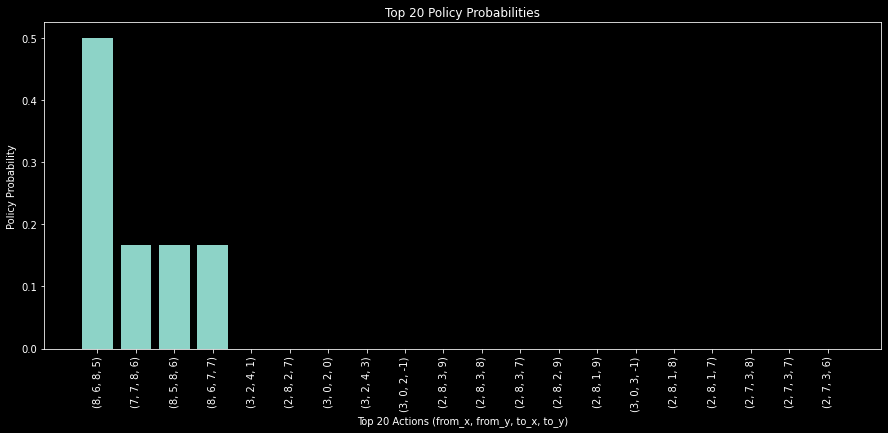

In [281]:
# Sort actions by their probabilities
sorted_actions = np.argsort(policy_targets[23])[::-1]

# Select top 20 actions
top_actions = sorted_actions[:20]
top_probabilities = policy_targets[23][top_actions]

# Get the action coordinates from the action indices
top_action_coordinates = [index_to_action[action_index] for action_index in top_actions]

# Create the bar plot with top 20 moves
plt.figure(figsize=(15, 6))
plt.bar(range(20), top_probabilities)
plt.xticks(range(20), top_action_coordinates, rotation=90)
plt.xlabel('Top 20 Actions (from_x, from_y, to_x, to_y)')
plt.ylabel('Policy Probability')
plt.title('Top 20 Policy Probabilities')

plt.show()

[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0 -5  0  0  0  0]
 [ 0  0  2  1 -1 -3 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
value -0.07967952638864517


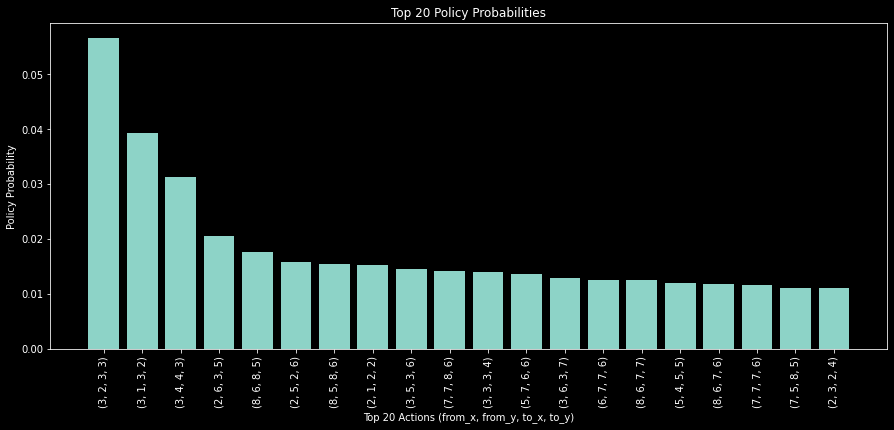

In [292]:
encoded_state = states[3]
print(get_decoded_state(encoded_state))

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet( 9, 128, device=device)
model.load_state_dict(torch.load('model_10.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()


print("value" , value)

# Sort actions by their probabilities
sorted_actions = np.argsort(policy)[::-1]

# Select top 20 actions
top_actions = sorted_actions[:20]
top_probabilities = policy[top_actions]

# Get the action coordinates from the action indices
top_action_coordinates = [index_to_action[action_index] for action_index in top_actions]

# Create the bar plot with top 20 moves
plt.figure(figsize=(15, 6))
plt.bar(range(20), top_probabilities)
plt.xticks(range(20), top_action_coordinates, rotation=90)
plt.xlabel('Top 20 Actions (from_x, from_y, to_x, to_y)')
plt.ylabel('Policy Probability')
plt.title('Top 20 Policy Probabilities')

plt.show()

### Data Augmentation 